# Filtr Kalmana

Na podstawie <https://www.kalmanfilter.net/>

## Wprowadzenie i podstawowe pojęcia

**Średnia** (*mean*) - średnia wartość obliczona na podstawie znanego stanu **całej** populacji

$$ V_{mean} = \frac{1}{N}\sum^{N}_{n=1}V_n $$

In [1]:
import numpy as np

coin_values = np.array([5, 5, 10, 10, 10])
mean = np.mean(coin_values)

print(f"Wartości: {coin_values}")
print(f"Średnia: {mean}")

Wartości: [ 5  5 10 10 10]
Średnia: 8.0


**Wartość oczekiwana** (*expected value*) - wartość określająca spodziewany wynik ukrytej zmiennej

$$ W = \frac{1}{N}\sum^{N}_{n=1}W_n $$

In [2]:
import numpy as np

generator = np.random.default_rng()

random_values = np.array(generator.normal(loc=80.0, scale=0.5, size=5))
expected_value = np.mean(random_values)

print(f"Losowe wartości: {random_values}")
print(f"Wartość oczekiwana: {expected_value}")

Losowe wartości: [80.15437792 79.95251277 79.51793712 79.87190855 80.47320519]
Wartość oczekiwana: 79.99398830784553


**Wariancja** (*variance*) - miara rozrzutu wartości zbioru od jego średniej

$$ \sigma^2 = \frac{1}{N} \sum^{N}_{n=1}(x_n - \mu)^2 $$

In [3]:
import numpy as np

# zakładamy że jest to cała populacja
values = np.array(generator.normal(loc=1.9, scale=0.2, size=5))
mean = np.mean(values)
variance = np.var(values)

print(f"Wartości: {values}")
print(f"Średnia: {mean}")
print(f"Wariancja: {variance}")

Wartości: [1.46517804 2.11542872 1.9918249  1.54535568 2.03478421]
Średnia: 1.8305143114060276
Wariancja: 0.0727419116244795


**Odchylenie standardowe** (*standard deviation*) - pierwiastek kwadratowy wariancji 

$$ \sigma = \sqrt{\sigma^2} = \sqrt{\frac{1}{N} \sum^{N}_{n=1}(x_n - \mu)^2} $$

In [4]:
import numpy as np

std_deviation = np.std(values)
print(f"Odchylenie standardowe: {std_deviation}")

Odchylenie standardowe: 0.2697070848614836


Podczas **estymacji** wariancji i odchylenia standardowego z **części populacji** należy zastosować dzielnik $\frac{1}{N-1}$ zamiast $\frac{1}{N}$ (Poprawka Bessela)

$$ \sigma = \sqrt{\sigma^2} = \sqrt{\frac{1}{N - 1} \sum^{N}_{n=1}(x_n - \mu)^2} $$

### Rozkład normalny (*normal distribution*)

Rozkład normalny (rozkład Gaussa) to krzywa dzwonowa opisana następującym wzorem:

$$ f(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}}e^{\frac{-(x-\mu)^2}{2\sigma^2}} $$


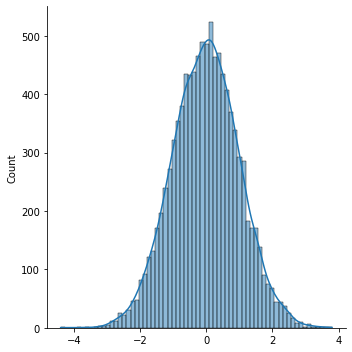

In [5]:
import seaborn as sns

values = generator.normal(loc=0.0, scale=1.0, size=10000)
sns.displot(values, kde=True)

### Estymacja, dokładność i precyzja

**Estymacja** (oszacowanie) polega na ocenie ukrytego stanu danego systemu. Przykładem może być pozycja samolotu - nie znamy dokładnej pozycji, ale możemy ją estymować za pomocą odpowiednich czujników, takich jak radar. W przypadku pojazdów naziemnych, możemy estymować pozycję na podstawie odometrów (na przykład enkoderów) lub czujników inercyjnych.

Estymacja może być znacznie poprawiona poprzez użycie różnych źródeł danych i aplikację filtrów oraz algorytmów pomagających w śledzeniu (takich jak filtr Kalmana). Każda wartość którą obliczymy na podstawie takich obserwacji jest estymatą.

**Dokładność** (*accuracy*) określa jak blisko prawdziwej wartości jest wartość zmierzona.
**Precyzja** (*precision*) określa jak bardzo różnią się od siebie wartości zmierzone dla tej samej wartości parametru (jak szeroko są rozsiane, jak duże jest ich odchylenie standardowe).

Systemy o wysokiej precyzji mają niską wariancję pomiarów, a systemy o niskiej precyzji - wysoką. Wariancja jest efektem losowego błędu pomiarowego.

Systemy o niskiej dokładności wprowadzają systematyczne przekłamanie (*bias*), które można stosunkowo łatwo wyeliminować poprzez odjęcie go od pomiarów, jeśli wiemy ile wynosi. Jeśli nie wiemy, lub nie możemy tego sprawdzić, nie ma innej możliwości na skompensowanie tego błędu.

Niską precyzję można skompensować poprzez uśrednianie zmierzonych wartości.

## Filtr alfa-beta-gamma

### Przykład 1 - pomiar wagi sztabek złota

Sztabka złota to system statyczny - nie zmienia swojego stanu w czasie w którym go rozpatrujemy.
Do pomiaru wagi użyjemy wagi z zerowym przekłamaniem (*biasem*), ale każdy pomiar będzie obarczony pewnym błędem.

Żeby estymować stan systemu (wagę sztabki), możemy wykonać kilka pomiarów i je uśrednić

W momencie $n$, estymata $\hat{x}_{n,n}$ będzie średnią wszystkich poprzednich pomiarów:

$$ \hat{x}_{n,n} = \frac{1}{n}(z_1 + z_2 + ... + z_{n-1} + z_n) = \frac{1}{n}\sum^{n}_{i=1}(z_i) $$

gdzie:

* $x$ to prawdziwa wartość wagi (której nie znamy, a którą estymujemy)
* $z_n$ to pomiar wartości w momencie $n$
* $\hat{x}_{n,n}$ to estymata $x$ w momencie $n$ (po wykonaniu pomiaru $z_n$)
* $\hat{x}_{n,n-1}$ to poprzednia estymata $x$ w momencie $n-1$ (po wykonaniu pomiaru $z_{n-1}$)
* $\hat{x}_{n+1,n}$ to estymata **przyszłego** stanu $(n+1)$ zmiennej $x$. Estymata ta jest obliczona w momencie $n$ (po wykonaniu pomiaru $z_n$). Innymi słowy, jest to przewidywany stan systemu.

W tym przypadku, dynamiczny model systemu jest stały, więc $\hat{x}_{n+1,n} = \hat{x}_{n,n}$

Powyższy wzór nie jest optymalny dla naszych zastosowań, ponieważ wymaga on trzymania wszystkich zmierzonych wartości w pamięci i obliczania wszystkich poprzednich stanów w celu estymacji kolejnego. Możemy nieco zmodyfikować ten wzór do poniższej postaci (pełny dowód przedstawiony jest tutaj: <https://www.kalmanfilter.net/alphabeta.html>)

$$ \hat{x}_{n,n} = \frac{1}{n}\sum^{n}_{i=1}(z_i) = \hat{x}_{n-1,n-1} + \frac{1}{n}(z_n - \hat{x}_{n-1,n-1}) $$

gdzie $\hat{x}_{n-1,n-1}$ jest estymowanym stanem zmiennej $x$ w momencie $n-1$, obliczonym na podstawie pomiaru wykonanego w momencie $n-1$.

Jak wyżej wspomniałem, analizowany przez nas system jest statyczny, co oznacza że przewidywany stan systemu powinien być równy estymowanemu stanowi, co można zapisać w następujący sposób: $\hat{x}_{n,n-1} = \hat{x}_{n-1,n-1}$

Na tej podstawie, można zapisać wzór na estymację aktualnego stanu na podstawie stanów poprzednich:

$$ \hat{x}_{n,n} = \hat{x}_{n,n-1} + \frac{1}{n}(z_n - \hat{x}_{n,n-1}) $$

Równanie to jest jednym z pięciu równań filtra Kalmana - równanie aktualizacji stanu (*State Update Equation*).

Tłumacząc je na język naturalny, oznacza ono że **estymata aktualnego stanu** jest równa **przewidywanej wartości stanu** plus **mnożnik** razy (**wartość pomiaru** minus **przewidywana wartość stanu**).
Mnożnik $\frac{1}{n}$ jest specyficzny dla naszego przypadku - w filtrze Kalmana nazwany jest **wzmocnieniem kalmana** (*Kalman Gain*) i zmienia się z kolejnymi iteracjami filtru.

Podstawiając $\alpha_n$ za nasz mnożnik, otrzymujemy następujące równanie aktualizacji stanu:

$$ \hat{x}_{n,n} = \hat{x}_{n,n-1} + \alpha_n (z_n - \hat{x}_{n,n-1}) $$

$ (z_n - \hat{x}_{n,n-1}) $ to fragment z pomiarem, nazywany również **innowacją**, ponieważ dostarcza nowe informacje.

W naszym przypadku, mnożnik $\frac{1}{n}$ zmniejsza się wraz z ilością pomiarów. Oznacza to że na początku nie mamy wystarczająco dużo informacji o aktualnym stanie, więc nowe wartości dostarczane do naszego estymatora będą miały większą wagę. Wraz z pojawianiem się kolejnych danych, będą one mieć coraz mniejszy wpływ na końcowy wynik.

Zanim wykonamy pierwszy pomiar, potrzebujemy jakiejś wartości systemu za pomocą której zainicjalizujemy nasz filtr - im bliższa jest ona prawdziwemu stanowi, tym lepiej. Wartość ta nazywana jest **wstępną wartością** (*initial guess*).

#### Algorytm estymacji

Poniższy flowchart przedstawia algorytm estymacji wykorzystany w tym przykładzie:

![est_1](./img//ex1_estimationAlgorithm.png)

#### Przykład numeryczny

##### Iteracja 0

**Inicjalizacja**

Załóżmy że sztabka waży 1000 gram. Ta wartość będzie wykorzystana jako wstępna wartość dla algorytmu.

$$ \hat{x}_{0,0} = 1000g $$

**Predykcja**

Waga sztabki nie powinna się zmienić (system jest statyczny), więc nasza estymata wynosi tyle samo co aktualny stan systemu

$$ \hat{x}_{1,0} = \hat{x}_{0,0} = 1000g $$

##### Iteracja 1

**Krok 1**

Wykonujemy pomiar

$$ z_1 = 1030g $$

**Krok 2**

Obliczamy mnożnik. W naszym przykładzie, $\alpha_n = \frac{1}{n}$, więc

$$ \alpha_1 = \frac{1}{1} = 1 $$

Następnie obliczamy aktualną estymację stanu systemu za pomocą równania aktualizacji stanu

$$ \hat{x}_{1,1} = \hat{x}_{1,0} + \alpha_1 (z_1 - \hat{x}_{1,0}) = 1000 + 1(1030 - 1000) = 1030g $$

W tym konkretnym przypadku pierwsza zmierzona wartość zastąpiła wstępną wartość, ponieważ $\alpha_1 = 1$,

**Krok 3**

Dynamiczny model systemu jest statyczny - nie przewidujemy że waga sztabki się zmieni - więc przewidywany stan systemu jest równy aktualnemu, estymowanemu stanowi

$$ \hat{x}_{2,1} = \hat{x}_{1,1} = 1030g $$

##### Iteracja 2

Po odstępie czasowym, przewidywany stan systemu z poprzedniej iteracji staje się poprzednią estymatą

$$ \hat{x}_{2,1} = 1030g $$

**Krok 1**

Wykonujemy kolejny pomiar

$$ z_2 = 989g $$

**Krok 2**

Obliczamy mnożnik

$$ \alpha_2 = \frac{1}{2} $$

oraz aktualną estymację

$$ \hat{x}_{2,2} = \hat{x}_{2,1} + \alpha_2 (z_2 - \hat{x}_{2,1}) = 1030 + \frac{1}{2}(989 - 1030) = 1009.5g $$

**Krok 3**

$$ \hat{x}_{3,2} = \hat{x}_{2,2} = 1009.5g $$

etc, etc.

Poniżej algorytm w postaci kodu, oraz wynik jego działania

   n  Measurements    Estimates  True value
0  0          1030  1030.000000        1010
1  1           989  1009.500000        1010
2  2          1017  1012.000000        1010
3  3          1009  1011.250000        1010
4  4          1013  1011.600000        1010
5  5           979  1006.166667        1010
6  6          1008  1006.428571        1010
7  7          1042  1010.875000        1010
8  8          1012  1011.000000        1010
9  9          1011  1011.000000        1010


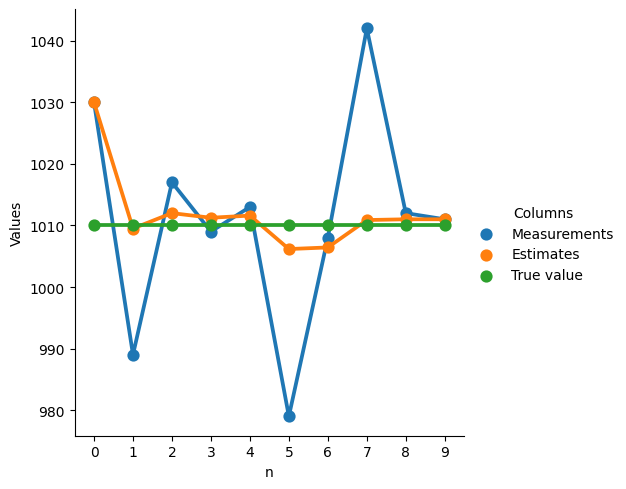

In [6]:
import pandas as pd
import seaborn as sns


def factor(value_index: int) -> float:
    return 1.0 / float(value_index)


def current_estimate(
    predicted_value: float, value_index: int, measurement: float
) -> float:
    return predicted_value + (factor(value_index) * (measurement - predicted_value))


initial_guess = 1000
true_value = 1010
measurements = [1030, 989, 1017, 1009, 1013, 979, 1008, 1042, 1012, 1011]
# oblicz pierwszą estymatę
estimates = [current_estimate(initial_guess, 1, measurements[0])]
# oblicz resztę
for n in range(1, len(measurements)):
    estimates.append(current_estimate(estimates[n - 1], n + 1, measurements[n]))

# stwórz ramkę danych do wizualizacji

df = pd.DataFrame(
    {
        "n": list(range(len(measurements))),
        "Measurements": measurements,
        "Estimates": estimates,
        "True value": [true_value] * len(measurements),
    }
)

sns_df = df.melt("n", var_name="Columns", value_name="Values")

print(df)

sns.catplot(data=sns_df, x="n", y="Values", hue="Columns", kind="point")


Możemy zauważyć że nasz algorytm dość precyzyjnie estymował prawdziwą wartość wagi sztabki złota, która wynosi 1010g. Widzimy również że im więcej pomiarów zostało wykonanych, tym mniejszy wpływ mają na estymowaną wartość.

### Przykład 2 - śledzenie trasy samolotu lecącego ze stałą prędkością (filtr alfa-beta)

Ten przykład skupi się na dynamicznym systemie, który zmienia swój stan w czasie. Konkretnie, będziemy śledzić samolot lecący ze stałą prędkością za pomocą filtra $\alpha$-$\beta$

Przyjmijmy że opisywany samolot porusza się w jednowymiarowej przestrzeni i oddala się od radaru za pomocą którego będziemy mierzyli jego odległość w czasie. W jednowymiarowym świecie, kąt radaru w stosunku do samolotu jest stały, jak również i wysokość na której porusza się samolot.

$x_n$ będzie odległością między radarem a samolotem w momencie $n$. Prędkość samolotu jest zdefiniowana jako zmiana odległości w czasie - innymi słowy, jest to pochodna odległości.

$$ \dot{x} = v = \frac{dx}{dt} $$

Zakładając że prędkość jest stała, dynamiczny model systemu może być opisany dwoma równaniami ruchu:

$$ x_{n+1} = x_n + \Delta t \dot{x}_n $$
$$ \dot{x}_{n+1} = \dot{x}_n $$

Równania te mówią, że odległość samolotu w momencie $(n+1)$-tego pomiaru jest równa odległości w momencie $n$-tego pomiaru, plus szybkości samolotu pomnożonej przez czas między pomiarami. Zakładamy również że prędkość jest stała, więc prędkość w $(n+1)$-tym momencie będzie taka sama jak w $n$-tym momencie.

Powyższe równania nazywane są równaniami ekstrapolacji stanu (*State Extrapolation Equation*), lub równaniami przejścia/predykcji (*Transition*/*Prediction Equation*) i są jednymi z równań występujących w filtrze Kalmana. Pozwalają one na ekstrapolację aktualnego stanu systemu na przyszły stan - czyli predykcję stanu.

W poprzednim przykładzie również zastosowane było równanie ekstrapolacji stanu, lecz ze względu na statyczność systemu było ono równe poprzedniemu stanowi. Przedstawione wyżej równania ekstrapolacji stanu są specyficzne dla naszego przypadku, musimy jeszcze zmodyfikować równania aktualizacji stanu.

#### Filtr alfa-beta

Załóżmy że czas między pomiarami radaru $\Delta t$ wynosi 5 sekund. Załóżmy również ze w momencie $(n-1)$ odległość samolotu od radaru wynosi 30000m, a szybkość 40m/s.
Za pomocą równań ekstrapolacji stanu możemy przewidzieć pozycję samolotu w momencie $n$:

$$ \hat{x}_{n,n-1} = \hat{x}_{n-1,n-1} + \Delta t \hat{\dot{x}}_{n-1,n-1} = 30000m + 5s \cdot 40m/s = 30200m $$

Szybkość samolotu w momencie $n$ wynosi

$$ \hat{\dot{x}}_{n,n-1} = \hat{\dot{x}}_{n-1,n-1} = 40m/s $$

Radar w momencie $n$ zmierzył odległość $z_n$ równą 30110m, a nie 30200m - którą obliczyliśmy. Różnica wynosi 90m i istnieją dwa potencjalne powody przez które się pojawiła:
* Pomiar wykonywany przez radar nie jest dokładny
* Szybkość samolotu się zmieniła. Nowa szybkość samolotu, obliczona na podstawie pomiaru, wynosi $\frac{30110m - 30000m}{5s} = 22m/s$

Nie wiemy jednak który z tych powodów jest prawdziwy.

Rozpiszmy równania aktualizacji stanu dla szybkości:

$$ \hat{\dot{x}}_{n,n} = \hat{\dot{x}}_{n,n-1} + \beta \left( \frac{z_n - \hat{x}_{n,n-1}}{\Delta t} \right) $$

Wartość współczynnika $\beta$ zależy od dokładności radaru. Możemy więc nią manipulować. Załóżmy że $\sigma$ (odchylenie standardowe) błędu pomiarowego radaru wynosi 20m. W takim przypadku, różnica rzędu 90m najprawdopodobniej wynika ze zmiany szybkości samolotu, ponieważ jest to znacznie większa wartość niż $\sigma$. Powinniśmy więc w takim przypadku ufać odczytowi z radaru bardziej niż naszej predykcji, więc współczynnik $\beta$ powinien być większy. Przy założeniu że $\beta$ wynosi 0.9, obliczamy następującą szybkość:

$$ \hat{\dot{x}}_{n,n} = \hat{\dot{x}}_{n,n-1} + \beta \left( \frac{z_n - \hat{x}_{n,n-1}}{\Delta t} \right) = 40m/s + 0.9 \left( \frac{30110m - 30200m}{5s} \right) = 23.8m/s $$

Z kolei jeśli $\sigma$ miałaby wartość 150m, to jest ona większa od różnicy 90m którą otrzymaliśmy, więc można założyć że wzięła się ona ze względu na błąd pomiarowy. W takim przypadku $\beta$ powinna być mała, na przykład 0.1, co dałoby nam szybkość

$$ \hat{\dot{x}}_{n,n} = \hat{\dot{x}}_{n,n-1} + \beta \left( \frac{z_n - \hat{x}_{n,n-1}}{\Delta t} \right) = 40m/s + 0.1 \left( \frac{30110m - 30200m}{5s} \right) = 38.2m/s $$

Współczynnik $\beta$, w przeciwieństwie do współczynnika $\alpha$ z poprzedniego przykładu, nie zmienia się co iterację - jest on stały w naszym przypadku, oraz ściśle zależny od dokładności narzędzia pomiarowego.

Równania aktualizacji stanu dla szybkości i pozycji są nazywane równaniami aktualizacji $\alpha$-$\beta$.

Dla pozycji:

$$ \hat{x}_{n,n} = \hat{x}_{n,n-1} + \alpha (z_n - \hat{x}_{n,n-1}) $$

Dla szybkości:

$$ \hat{\dot{x}}_{n,n} = \hat{\dot{x}}_{n,n-1} + \beta \left( \frac{z_n - \hat{x}_{n,n-1}}{\Delta t} \right) $$

#### Algorytm estymacji

Poniższy obrazek przedstawia algorytm estymacji użyty w tym przykładzie. W przeciwieństwie do poprzedniego przykładu, tutaj współczynniki $\alpha$ i $\beta$ są podane. W filtrze Kalmana są one zastąpione wzmocnieniem kalmana obliczanym w każdej iteracji.

![est_2](./img/ex2_estimationAlgorithm.png)

#### Przykład numeryczny

Przyjmijmy że samolot oddala sie od radaru w jednowymiarowym świecie. Parametry dla filtra alfa-beta będą następujące:

* $\alpha = 0.2$
* $\beta = 0.1$

Czas między pomiarami wynosi 5 sekund. Dla przykładu założyliśmy że radar będzie miał bardzo małą precyzję.

##### Iteracja 0

**Inicjalizacja**

W początkowym momencie $n = 0$ zakładamy że

$$ \hat{x}_{0,0} = 30000m $$
$$ \hat{\dot{x}}_{0,0} = 40m/s $$

**Predykcja**

Możemy ekstrapolować szybkość i odległość samolotu za pomocą równań ekstrapolacji stanu

$$ \hat{x}_{n+1,n} = \hat{x}_{n,n} + \Delta t \hat{\dot{x}}_{n,n} \rightarrow \hat{x}_{1,0} = \hat{x}_{0,0} + \Delta t \hat{\dot{x}}_{0,0} = 30000m + 5s \cdot 40m/s = 30200m $$
$$ \hat{\dot{x}}_{n+1,n} = \hat{\dot{x}}_{n,n} \rightarrow \hat{\dot{x}}_{1,0} = \hat{\dot{x}}_{0,0} = 40m/s $$

##### Iteracja 1

W kolejnej iteracji jako wartości początkowe bierzemy poprzednie ekstrapolacje stanu

$$ \hat{x}_{n,n-1} = \hat{x}_{1,0} = 30200m $$
$$ \hat{\dot{x}}_{n,n-1} = \hat{\dot{x}}_{1,0} = 40m/s $$

**Krok 1**

Radar wykonuje pomiar

$$ z_1 = 30110m $$

**Krok 2**

Obliczamy nową estymowaną wartość stanu za pomocą równań aktualizacji stanu

$$ \hat{x}_{1,1} = \hat{x}_{1,0} + \alpha (z_1 - \hat{x}_{1,0}) = 30200m + 0.2 (30110m - 30200m) = 30182m $$ 
$$ \hat{\dot{x}}_{1,1} = \hat{\dot{x}}_{1,0} + \beta \left( \frac{z_1 - \hat{x}_{1,0}}{\Delta t} \right) = 40m/s + 0.1 \left( \frac{30110m - 30200m}{5s} \right) = 38.2m/s $$

**Krok 3**

Obliczany estymowaną wartość kolejnego stanu za pomocą równań estymacji stanu

$$ \hat{x}_{2,1} = \hat{x}_{1,1} + \Delta t \hat{\dot{x}}_{1,1} = 30182m + 5s \cdot 38.2m/s = 30373m $$
$$ \hat{\dot{x}}_{2,1} = \hat{\dot{x}}_{1,1} = 38.2m/s $$

##### Iteracja 2

Po czasie $\Delta t$, poprzednia estymowana wartość kolejnego stanu staje się aktualną wartością początkową stanu

$$ \hat{x}_{n,n-1} = \hat{x}_{2,2} = 30373m $$
$$ \hat{\dot{x}}_{n,n-1} = \hat{\dot{x}}_{2,1} = 38.2m/s $$

**Krok 1**

Radar wykonuje pomiar

$$ z_1 = 30265m $$

**Krok 2**

Obliczamy nową estymowaną wartość stanu za pomocą równań aktualizacji stanu

$$ \hat{x}_{2,2} = \hat{x}_{2,1} + \alpha (z_1 - \hat{x}_{2,1}) = 30373m + 0.2 (30265m - 30373m) = 30351.4m $$ 
$$ \hat{\dot{x}}_{2,2} = \hat{\dot{x}}_{2,1} + \beta \left( \frac{z_1 - \hat{x}_{2,1}}{\Delta t} \right) = 38.2/s + 0.1 \left( \frac{30265m - 30373m}{5s} \right) = 36m/s $$

**Krok 3**

Obliczany estymowaną wartość kolejnego stanu za pomocą równań estymacji stanu

$$ \hat{x}_{3,2} = \hat{x}_{2,2} + \Delta t \hat{\dot{x}}_{2,2} = 30351.4m + 5s \cdot 36.2m/s = 30531.6m $$
$$ \hat{\dot{x}}_{3,2} = \hat{\dot{x}}_{2,2} = 36m/s $$

Poniżej przedstawione obliczenia w języku Python oraz wyniki działania algorytmu

   Time  Measurements  Distance (predicted)  Distance (estimated)  \
0   5.0       30110.0          30200.000000          30182.000000   
1  10.0       30265.0          30373.000000          30351.400000   
2  15.0       30740.0          30531.600000          30573.280000   
3  20.0       30750.0          30774.320000          30769.456000   
4  25.0       31135.0          30968.064000          31001.451200   
5  30.0       31015.0          31216.752800          31176.402240   
6  35.0       31180.0          31371.528560          31333.222848   
7  40.0       31610.0          31509.196312          31529.357050   
8  45.0       31960.0          31715.410882          31764.328706   
9  50.0       31865.0          31974.841450          31952.873160   

     True value  
0  30000.000000  
1  30222.222222  
2  30444.444444  
3  30666.666667  
4  30888.888889  
5  31111.111111  
6  31333.333333  
7  31555.555556  
8  31777.777778  
9  32000.000000  


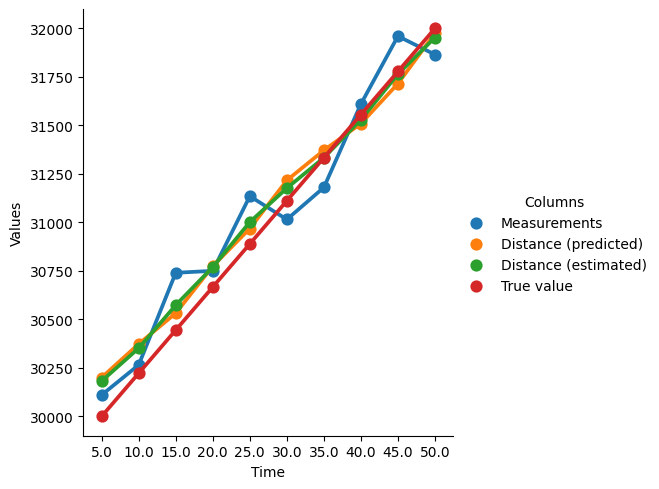

In [7]:
from typing import List
import pandas as pd
import seaborn as sns
import numpy as np


def extrapolate_distance(distance: float, velocity: float, interval: float) -> float:
    return distance + (interval * velocity)


def extrapolate_velocity(velocity: float) -> float:
    return velocity


def update_distance(distance: float, alpha: float, measurement: float) -> float:
    return distance + (alpha * (measurement - distance))


def update_velocity(
    velocity: float, beta: float, measurement: float, distance: float, interval: float
) -> float:
    return velocity + (beta * ((measurement - distance) / interval))


def calculate_movement_data(
    starting_distance: float,
    starting_velocity: float,
    interval: float,
    alpha: float,
    beta: float,
    measurements: List[float],
) -> pd.DataFrame:
    # obliczamy pierwszy stan na podstawie początkowego
    distance_predictions = [
        extrapolate_distance(starting_distance, starting_velocity, interval)
    ]
    velocity_predictions = [extrapolate_velocity(starting_velocity)]
    distance_estimates = []
    velocity_estimates = []

    # a następnie wszystkie kolejne na podstawie pomiarów
    for n in range(len(measurements)):
        predicted_distance = distance_predictions[n]
        predicted_velocity = velocity_predictions[n]
        measurement = measurements[n]

        estimated_distance = update_distance(predicted_distance, alpha, measurement)
        estimated_velocity = update_velocity(
            predicted_velocity, beta, measurement, predicted_distance, interval
        )

        next_predicted_distance = extrapolate_distance(
            estimated_distance, estimated_velocity, interval
        )
        next_predicted_velocity = extrapolate_velocity(estimated_velocity)

        distance_estimates.append(estimated_distance)
        velocity_estimates.append(estimated_velocity)
        distance_predictions.append(next_predicted_distance)
        velocity_predictions.append(next_predicted_velocity)

    # stwórzmy ramkę danych do wizualizacji

    df_data = {
        "Time": np.linspace(5, 5 * len(measurements), len(measurements)),
        "Measurements": measurements,
        "Distance (predicted)": distance_predictions[:-1],
        "Distance (estimated)": distance_estimates,
    }

    return pd.DataFrame(df_data)


alpha: float = 0.2
beta: float = 0.1
interval: float = 5.0
starting_distance: float = 30000.0
starting_velocity: float = 40.0
measurements: List[float] = [
    30110.0,
    30265.0,
    30740.0,
    30750.0,
    31135.0,
    31015.0,
    31180.0,
    31610.0,
    31960.0,
    31865.0,
]

df = calculate_movement_data(
    starting_distance, starting_velocity, interval, alpha, beta, measurements
)

true_value_df = pd.DataFrame(
    {
        "True value": np.linspace(30000, 32000, len(measurements)),
    }
)

whole_df = pd.concat([df, true_value_df], axis=1)

print(whole_df)

sns_df = whole_df.melt("Time", var_name="Columns", value_name="Values")

sns.catplot(data=sns_df, x="Time", y="Values", hue="Columns", kind="point")


Łatwo zauważyć, że estymowane i przewidywane wartości są bardzo bliskie rzeczywistych. Możemy też łatwo sprawdzić jak wyglądałyby obliczenia, gdybyśmy znacznie bardziej ufali wartościom otrzymywanym z radaru, poprzez zmianę wartości współczynników $\alpha$ i $\beta$ na większe:

   Time  Measurements  Distance (predicted)  Distance (estimated)  \
0   5.0       30110.0          30200.000000          30128.000000   
1  10.0       30265.0          30283.000000          30268.600000   
2  15.0       30740.0          30414.600000          30674.920000   
3  20.0       30750.0          30983.620000          30796.724000   
4  25.0       31135.0          30988.614000          31105.722800   
5  30.0       31015.0          31370.805800          31086.161160   
6  35.0       31180.0          31173.341260          31178.668252   
7  40.0       31610.0          31269.177722          31541.835544   
8  45.0       31960.0          31802.756153          31928.551231   
9  50.0       31865.0          32268.093763          31945.618753   

     True value  
0  30000.000000  
1  30222.222222  
2  30444.444444  
3  30666.666667  
4  30888.888889  
5  31111.111111  
6  31333.333333  
7  31555.555556  
8  31777.777778  
9  32000.000000  


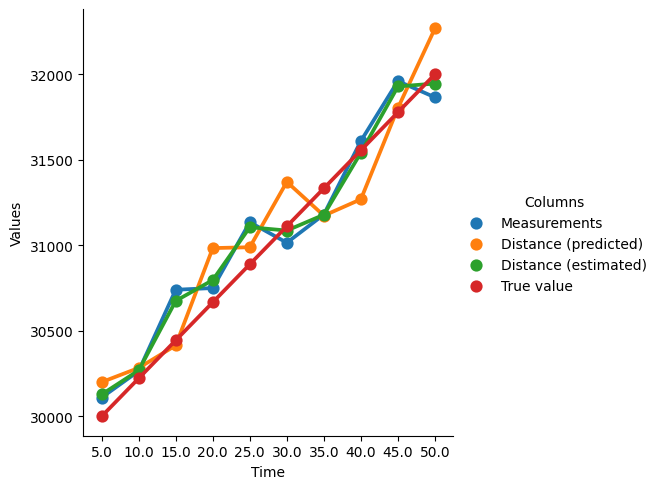

In [8]:
alpha: float = 0.8
beta: float = 0.5

df = calculate_movement_data(
    starting_distance, starting_velocity, interval, alpha, beta, measurements
)

true_value_df = pd.DataFrame(
    {
        "True value": np.linspace(30000, 32000, len(measurements)),
    }
)

whole_df = pd.concat([df, true_value_df], axis=1)

print(whole_df)

sns_df = whole_df.melt("Time", var_name="Columns", value_name="Values")

sns.catplot(data=sns_df, x="Time", y="Values", hue="Columns", kind="point")


Widzimy tutaj że estymowane i przewidywane wartości są znacznie bardziej "rozrzucone" i dalsze od prawdziwych wartości. Wynika to z niskiej dokładności naszego "radaru" - nasz algorytm jest w stanie poradzić sobie z dużą wariancją błędów pomiarowych, jeśli będzie wiedział że dane mają dużą wariancję. Jeśli każemy mu ufać bardziej danym to będą miały one mocniejszy wpływ na stan naszego systemu, co w efekcie spowoduje że będzie on bardziej narażony na wpływ błędów pomiarowych.

Skutkiem ubocznym mocniejszego "wygładzania" danych przez filtr jest większa bezwładność stanu - szybkość zmian stanu naszego filtra jest bezpośrednio zależna od wybranego współczynnika, więc w przypadku gdy system faktycznie zacznie zmieniać szybko swój stan, filtr "wygładzi" te zmiany i spowoduje że będą one widoczne znacznie "łagodniej". Może to działać na naszą niekorzyść, jeśli system który mierzymy jest w stanie szybko zmieniać swój stan i będziemy chcieli równie szybko wykrywać te zmiany.

Współczynniki alfa i beta należy dobierać do precyzji czujnika z którego otrzymujemy dane.

### Przykład 3 - śledzenie przyspieszającego samolotu w jednym wymiarze

W tym przykładzie zastosujemy filtr alfa-beta do śledzenia samolotu poruszającego się ze stałym przyspieszeniem. W poprzednim przykładzie, przyspieszenie było stałe i równe 0 - samolot leciał z prędkością 40m/s przez całą drogę.
Rozpatrzmy teraz nieco lżejszy samolot - będzie poruszał się z prędkością 50m/s przez 15 sekund, a następnie zacznie przyspieszać 8m/s² przez kolejne 35 sekund. Będziemy śledzić ten samolot i użyjemy w tym celu filtra alfa-beta.

#### Przykład numeryczny

Rozpatrzmy samolot oddalający się od radaru w jednowymiarowym świecie.

Parametry filtra alfa-beta są następujące:
* $\alpha = 0.2$
* $\beta = 0.1$

Czas pomiędzy pomiarami wynosi 5 sekund.

##### Iteracja 0

**Inicjalizacja**

Wstępne założenia w momencie $n = 0$ to:

$$ \hat{x}_{0,0} = 30000m $$
$$ \hat{\dot{x}}_{0,0} = 50m/s $$

**Predykcja**

Wstępne założenia zostaną ekstrapolowane na kolejny moment $n = 1$ za pomocą równań ekstrapolacji stanu

$$ \hat{x}_{n+1,n} = \hat{x}_{n,n} + \Delta t \hat{\dot{x}}_{n,n} \rightarrow \hat{x}_{1,0} = \hat{x}_{0,0}  + \Delta t \hat{\dot{x}}_{0,0} = 30000m + 5s \cdot 50m/s = 30250m $$
$$ \hat{\dot{x}}_{n+1,n} = \hat{\dot{x}}_{n,n} \rightarrow \hat{\dot{x}}_{1,0} = \hat{\dot{x}}_{0,0} = 50m/s $$

Wyniki obliczeń przedstawione są poniżej:

   Time  Measurements  Distance (predicted)  Distance (estimated)  True value
0   5.0       30160.0          30250.000000          30232.000000     30250.0
1  10.0       30365.0          30473.000000          30451.400000     30500.0
2  15.0       30890.0          30681.600000          30723.280000     30750.0
3  20.0       31050.0          30974.320000          30989.456000     31100.0
4  25.0       31785.0          31248.064000          31355.451200     31650.0
5  30.0       32215.0          31667.752800          31777.202240     32400.0
6  35.0       33130.0          32144.228560          32341.382848     33350.0
7  40.0       34510.0          32806.986312          33147.589050     34500.0
8  45.0       36010.0          33783.493882          34228.795106     35850.0
9  50.0       37265.0          35087.350550          35522.880440     37400.0


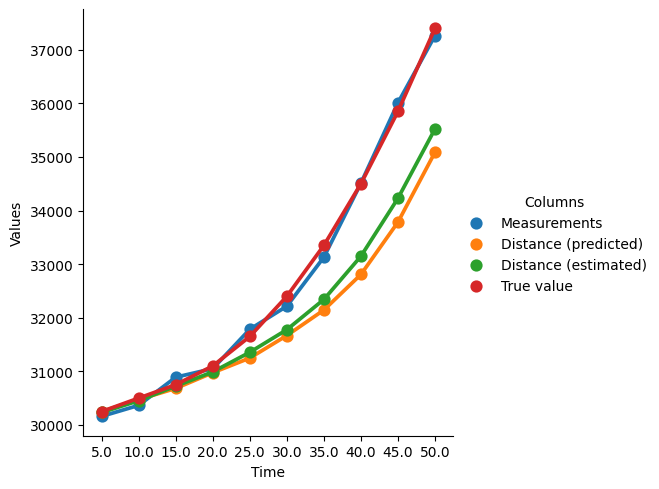

In [9]:
from typing import List


def velocity_at_time(
    starting_velocity: float, acceleration: float, time: float
) -> float:
    return starting_velocity + (acceleration * time)


def distance_at_time(
    starting_distance: float, starting_velocity: float, acceleration: float, time: float
) -> float:
    return (
        starting_distance
        + (starting_velocity * time)
        + ((acceleration * (time**2)) / 2.0)
    )


def true_aircraft_distance(n: int) -> float:
    if n >= 15:
        pre_acceleration_distance = distance_at_time(30000, 50, 0, 15.0)
        return distance_at_time(pre_acceleration_distance, 50, 8, n - 15)

    return distance_at_time(30000, 50, 0, float(n))


def true_aircraft_velocity(n: int) -> float:
    if n >= 15:
        pre_acceleration_velocity = 50
        return velocity_at_time(pre_acceleration_velocity, 8, n - 15)

    return 50


def true_aircraft_acceleration(n: int) -> float:
    if n >= 15:
        return 8

    return 0


alpha: float = 0.2
beta: float = 0.1
interval: float = 5.0
starting_distance: float = 30000.0
starting_speed: float = 50.0
measurements: List[float] = [
    30160.0,
    30365.0,
    30890.0,
    31050.0,
    31785.0,
    32215.0,
    33130.0,
    34510.0,
    36010.0,
    37265.0,
]

df = calculate_movement_data(
    starting_distance, starting_speed, interval, alpha, beta, measurements
)

true_value_df = pd.DataFrame(
    {"True value": [true_aircraft_distance(n) for n in range(5, 55, int(interval))]}
)

whole_df = pd.concat([df, true_value_df], axis=1)

print(whole_df)

sns_df = whole_df.melt("Time", var_name="Columns", value_name="Values")

sns.catplot(data=sns_df, x="Time", y="Values", hue="Columns", kind="point")


Prawdziwa wartość jest bardzo bliska pomiarom, ale przez niskie wartości współczynników alfa i beta nasz filtr doświadcza błędu opóźnienia (*lag error*), zwanego również błędem dynamicznym (*dynamic error*), systematycznym (*systematic error*) lub *bias error*.

### Przykład 4 - śledzenie przyspieszającego samolotu za pomocą filtra alfa-beta-gamma

W tym przykładzie będziemy śledzić samolot o stałej akceleracji z użyciem filtra alfa-beta-gamma. Filtr ten bierze pod uwagę stałą akcelerację obiektu.

Równania ekstrapolacji stanu będą wyglądać następująco:

$$ \hat{x}_{n+1,n} = \hat{x}_{n,n} + \hat{\dot{x}}_{n,n} \Delta t + \hat{\ddot{x}}_{n,n} \frac{\Delta t^2}{2} $$
$$ \hat{\dot{x}}_{n+1,n} = \hat{\dot{x}}_{n,n} + \hat{\ddot{x}}_{n,n} \Delta t $$
$$ \hat{\ddot{x}}_{n+1,n} = \hat{\ddot{x}}_{n,n} $$

gdzie $\ddot{x}_n$ to przyspieszenie (druga pochodna $x$).
Równanie aktualizacji stanu wygląda następująco:

$$ \hat{x}_{n,n} = \hat{x}_{n,n-1} + \alpha (z_n - \hat{x}_{n,n-1}) $$
$$ \hat{\dot{x}}_{n,n} = \hat{\dot{x}}_{n,n-1} + \beta \left( \frac{z_n - \hat{x}_{n,n-1}}{\Delta t} \right) $$
$$ \hat{\ddot{x}}_{n,n} = \hat{\ddot{x}}_{n,n-1} + \gamma \left( \frac{z_n - \hat{x}_{n,n-1}}{0.5 \Delta t^2} \right) $$

#### Przykład numeryczny

Przyjmijmy ostatni scenariusz z poprzedniego przykładu - samolot poruszać się będzie ze stałą szybkością 50m/s przez 15 sekund, a następnie zacznie przyspieszać ze stałą akceleracją 8m/s² przez kolejne 35 sekund.
Parametry filtra alfa-beta-gamma są następujące:

* $\alpha = 0.5$
* $\beta = 0.4$
* $\gamma = 0.1$

Czas między pomiarami $\Delta t$ wynosi 5 sekund.

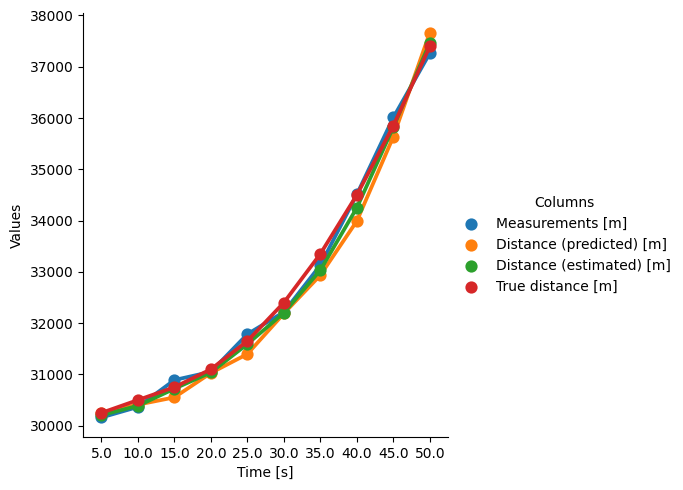

In [10]:
from typing import List
import pandas as pd
import numpy as np
import seaborn as sns


def extrapolate_distance(
    current_distance: float,
    current_velocity: float,
    current_acceleration: float,
    time: float,
) -> float:
    return (
        current_distance
        + (current_velocity * time)
        + (current_acceleration * ((time**2) / 2.0))
    )


def extrapolate_velocity(
    current_velocity: float, current_acceleration: float, time: float
) -> float:
    return current_velocity + (current_acceleration * time)


def extrapolate_acceleration(current_acceleration: float) -> float:
    return current_acceleration


def update_distance(
    previous_distance: float, alpha: float, measurement: float
) -> float:
    return previous_distance + (alpha * (measurement - previous_distance))


def update_velocity(
    previous_velocity: float,
    beta: float,
    measurement: float,
    previous_distance: float,
    time: float,
) -> float:
    return previous_velocity + (beta * ((measurement - previous_distance) / time))


def update_acceleration(
    previous_acceleration: float,
    gamma: float,
    measurement: float,
    previous_distance: float,
    time: float,
) -> float:
    return previous_acceleration + (
        gamma * ((measurement - previous_distance) / (0.5 * (time**2)))
    )


def calculate_movement_data(
    starting_distance: float,
    starting_velocity: float,
    starting_acceleration: float,
    time_interval: float,
    alpha: float,
    beta: float,
    gamma: float,
    measurements: List[float],
) -> pd.DataFrame:
    # obliczamy pierwszy stan na podstawie wartości początkowych
    distance_predictions: List[float] = [
        extrapolate_distance(
            starting_distance, starting_velocity, starting_acceleration, time_interval
        )
    ]
    velocity_predictions: List[float] = [
        extrapolate_velocity(starting_velocity, starting_acceleration, time_interval)
    ]
    acceleration_predictions: List[float] = [
        extrapolate_acceleration(starting_acceleration)
    ]

    distance_estimates: List[float] = []
    velocity_estimates: List[float] = []
    acceleration_estimates: List[float] = []

    # a następnie obliczamy kolejne predykcje i estymaty na podstawie pomiarów
    for n in range(len(measurements)):
        predicted_distance = distance_predictions[n]
        predicted_velocity = velocity_predictions[n]
        predicted_acceleration = acceleration_predictions[n]
        measurement = measurements[n]

        estimated_distance = update_distance(predicted_distance, alpha, measurement)
        estimated_velocity = update_velocity(
            predicted_velocity, beta, measurement, predicted_distance, time_interval
        )
        estimated_acceleration = update_acceleration(
            predicted_acceleration,
            gamma,
            measurement,
            predicted_distance,
            time_interval,
        )

        next_predicted_distance = extrapolate_distance(
            estimated_distance,
            estimated_velocity,
            estimated_acceleration,
            time_interval,
        )
        next_predicted_velocity = extrapolate_velocity(
            estimated_velocity, estimated_acceleration, time_interval
        )
        next_predicted_acceleration = extrapolate_acceleration(estimated_acceleration)

        distance_estimates.append(estimated_distance)
        velocity_estimates.append(estimated_velocity)
        acceleration_estimates.append(estimated_acceleration)

        distance_predictions.append(next_predicted_distance)
        velocity_predictions.append(next_predicted_velocity)
        acceleration_predictions.append(next_predicted_acceleration)

    # na koniec tworzymy i zwracamy dane w postaci ramki
    df_data = {
        "Time [s]": np.linspace(5, 5 * len(measurements), len(measurements)),
        "Measurements [m]": measurements,
        "Distance (predicted) [m]": distance_predictions[:-1],
        "Distance (estimated) [m]": distance_estimates,
        "Velocity (predicted) [m/s]": velocity_predictions[:-1],
        "Velocity (estimated) [m/s]": velocity_estimates,
        "Acceleration (predicted) [m/s^2]": acceleration_predictions[:-1],
        "Acceleration (estimated) [m/s^2]": acceleration_estimates,
    }

    return pd.DataFrame(df_data)


alpha: float = 0.5
beta: float = 0.4
gamma: float = 0.1
time_interval: int = 5
starting_distance: float = 30000.0
starting_velocity: float = 50.0
starting_acceleration: float = 0.0
measurements: List[float] = [
    30160.0,
    30365.0,
    30890.0,
    31050.0,
    31785.0,
    32215.0,
    33130.0,
    34510.0,
    36010.0,
    37265.0,
]

abg_df = calculate_movement_data(
    starting_distance,
    starting_velocity,
    starting_acceleration,
    time_interval,
    alpha,
    beta,
    gamma,
    measurements,
)

distance_df = abg_df[
    [
        "Time [s]",
        "Measurements [m]",
        "Distance (predicted) [m]",
        "Distance (estimated) [m]",
    ]
]

true_distance_df = pd.DataFrame(
    {
        "True distance [m]": [
            true_aircraft_distance(n) for n in range(5, 55, time_interval)
        ]
    }
)

distance_df = pd.concat([distance_df, true_distance_df], axis=1)

distance_df_melted = distance_df.melt(
    "Time [s]", var_name="Columns", value_name="Values"
)
sns.catplot(
    data=distance_df_melted, x="Time [s]", y="Values", hue="Columns", kind="point"
)


Widzimy że filtr alfa-beta-gamma umożliwił dość precyzyjne śledzenie samolotu. Spójrzmy jeszcze na wykres szybkości w czasie:

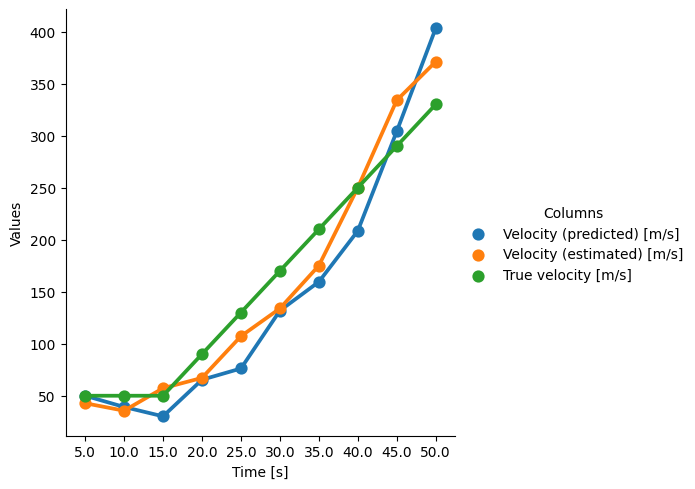

In [11]:
true_velocity_df = pd.DataFrame(
    {
        "True velocity [m/s]": [
            true_aircraft_velocity(n) for n in range(5, 55, time_interval)
        ]
    }
)

velocity_df = abg_df[
    ["Time [s]", "Velocity (predicted) [m/s]", "Velocity (estimated) [m/s]"]
]

velocity_df = pd.concat([velocity_df, true_velocity_df], axis=1)

velocity_df_melted = velocity_df.melt(
    "Time [s]", var_name="Columns", value_name="Values"
)

sns.catplot(
    data=velocity_df_melted, x="Time [s]", y="Values", hue="Columns", kind="point"
)


Oraz akceleracji w czasie:

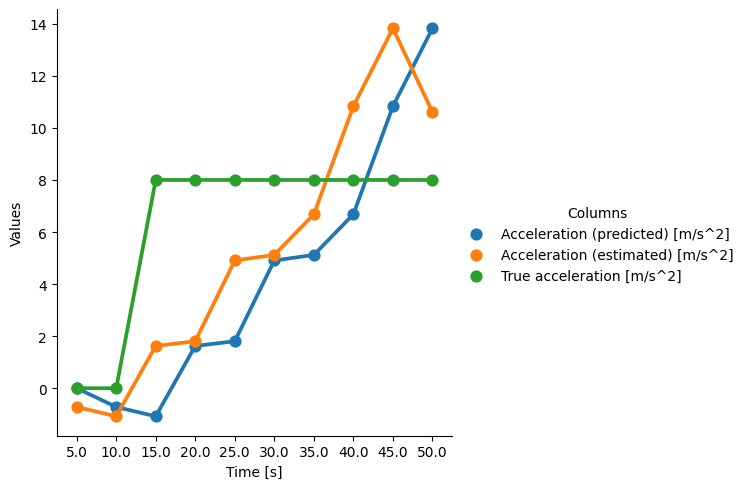

In [12]:
true_acceleration_df = pd.DataFrame(
    {
        "True acceleration [m/s^2]": [
            true_aircraft_acceleration(n) for n in range(5, 55, time_interval)
        ]
    }
)

acceleration_df = abg_df[
    ["Time [s]", "Acceleration (predicted) [m/s^2]", "Acceleration (estimated) [m/s^2]"]
]
acceleration_df = pd.concat([acceleration_df, true_acceleration_df], axis=1)

acceleration_df_melted = acceleration_df.melt(
    "Time [s]", var_name="Columns", value_name="Values"
)

sns.catplot(
    data=acceleration_df_melted, x="Time [s]", y="Values", hue="Columns", kind="point"
)


Łatwo zauważyć że filtr alfa-beta-gamma jest dobrym narzędziem, umożliwiającym estymację trasy obiektu ze zmienną akceleracją - eliminuje on *lag error* który zauważyliśmy podczas próby użycia filtru alfa-beta z tymi samymi danymi.

Ale co jeśli cel nie porusza się z jednostajną akceleracja, tylko manewruje? Prawdziwie dynamiczny model może uwzględniać "szarpanie" (zmieniającą się akcelerację), filtr alfa-beta-gamma ze stałymi współczynnikami nie będzie w stanie precyzyjnie estymować trasy takiego obiektu.

Filtr Kalmana bierze pod uwagę tego typu niepewności w dynamicznym modelu.

### Filtr alfa-beta-gamma: podsumowanie

Istnieją różne rodzaje filtrów alfa-beta-gamma, lecz operują one na tej samej zasadzie:
* Estymacja aktualnego stanu jest oparta na równaniach aktualizacji stanu
* Predykcja następnego stanu jest oparta na dynamicznych równaniach modelu

Główną różnicę stanowi wybór współczynników alfa, beta i gamma. Niektóre filtry używają stałych współczynników (jak nasze), inne dobierają je odpowiednio dla każdej iteracji. Wybór odpowiednich współczynników jest jednym z kluczowych czynników wpływających na precyzję działania filtru, jak również i wybór wartości początkowych.

Filtr Kalmana to jeden z wielu filtrów z kategorii alfa-beta-gamma.

## Jednowymiarowy filtr Kalmana

### Bez przetwarzania szumów

Filtr Kalmana jest oparty na pięciu równaniach, poznaliśmy do tej pory dwa:

* Równania aktualizacji stanu
* Równania modelu dynamicznego

W tej części wyprowadzimy pozostałe trzy wzory. Powróćmy do pierwszego przykładu z ważeniem sztabki złota - przeprowadziliśmy kilka pomiarów i na ich podstawie obliczyliśmy średnią, otrzymując następujące wyniki:

   n  Measurements    Estimates  True value
0  0          1030  1030.000000        1010
1  1           989  1009.500000        1010
2  2          1017  1012.000000        1010
3  3          1009  1011.250000        1010
4  4          1013  1011.600000        1010
5  5           979  1006.166667        1010
6  6          1008  1006.428571        1010
7  7          1042  1010.875000        1010
8  8          1012  1011.000000        1010
9  9          1011  1011.000000        1010


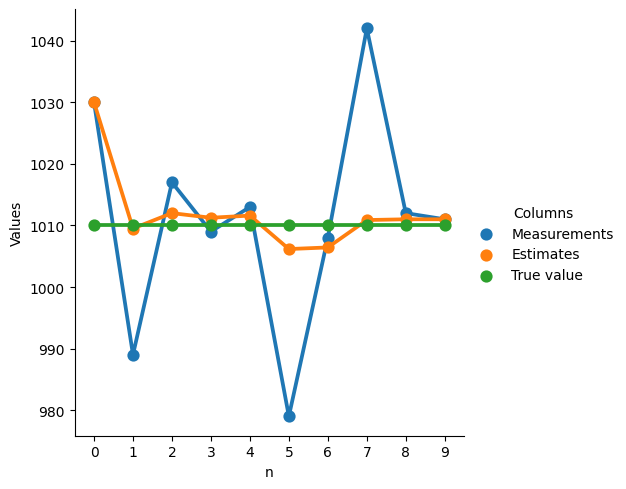

In [13]:
import pandas as pd
import seaborn as sns


def factor(value_index: int) -> float:
    return 1.0 / float(value_index)


def current_estimate(
    predicted_value: float, value_index: int, measurement: float
) -> float:
    return predicted_value + (factor(value_index) * (measurement - predicted_value))


initial_guess = 1000
true_value = 1010
measurements = [1030, 989, 1017, 1009, 1013, 979, 1008, 1042, 1012, 1011]
# oblicz pierwszą estymatę
estimates = [current_estimate(initial_guess, 1, measurements[0])]
# oblicz resztę
for n in range(1, len(measurements)):
    estimates.append(current_estimate(estimates[n - 1], n + 1, measurements[n]))

# stwórz ramkę danych do wizualizacji

df = pd.DataFrame(
    {
        "n": list(range(len(measurements))),
        "Measurements": measurements,
        "Estimates": estimates,
        "True value": [true_value] * len(measurements),
    }
)

sns_df = df.melt("n", var_name="Columns", value_name="Values")

print(df)

sns.catplot(data=sns_df, x="n", y="Values", hue="Columns", kind="point")

Na powyższym wykresie widać prawdziwą wagę sztabki, wartości zmierzone i średnią.

Różnica między pomiarem a prawdziwą wartością to **błąd pomiarowy**. Błędy pomiarowe są losowe, więc możemy je opisać za pomocą wariancji ($\sigma^2$). Wariancja błędów może być podana przez producenta urządzenia pomiarowego (tutaj: wagi), lub obliczona w procesie kalibracji. Wariancja błędu pomiarowego nazywana jest również **niepewnością pomiarową**.

Niepewność pomiarową oznaczymy symbolem $r$

Różnica między estymatą a prawdziwą wartością to **błąd estymacji**. Można zauważyć że staje się on coraz mniejszy, proporcjonalnie od ilości pomiarów - finalnie powinien on dążyć do zera, a wartość estymowana powinna dążyć do wartości prawdziwej. Nie wiemy jaki jest błąd estymacji, ale możemy oszacować **niepewność estymacji**.

Niepewność estymacji oznaczymy symbolem $p$.

Spójrzmy na **funkcję gęstości prawdopodobieństwa** pomiarów wagi. Na poniższym wykresie widoczne jest dziesięć pomiarów wagi.

* Pomiary są oznaczone niebieskimi liniami
* Prawdziwa wartość jest oznaczona czerwoną, przerywaną linią
* Zielona linia to funkcja gęstości prawdopodobieństwa pomiaru
* Zielony obszar to odchylenie standardowe pomiaru ($\sigma$), tj. istnieje 68.26% szansy że prawdziwa wartość znajduje się w tym obszarze

![PDFs](./img/PDFs.png)

Jak widać, 8 na 10 pomiarów jest wystarczająco dokładnych, by prawdziwa wartość leżała w odległości $1\sigma$ pomiaru.

Niepewność pomiarowa $r$ to wariancja pomiaru ($\sigma^2$)

#### Równanie wzmocnienia Kalmana w jednym wymiarze

W tym kroku wyprowadzimy trzecie równanie - **równianie wzmocnienia Kalmana**. Poniżej przedstawione jest uproszczone wyprowadzenie, matematyczna forma zostanie przedstawiona później.

W filtrze Kalmana, współczynnik alfa, beta i gamma są obliczane dynamicznie dla każdej iteracji filtra. Te parametry to **wzmocnienie kalmana** i są oznaczane symbolem $K_n$.

Równanie wzmocnienia Kalmana wygląda następująco:
$$ K_n = \frac{\text{Niepewność estymacji}}{\text{Niepewność estymacji} + \text{Niepewność pomiaru}} = \frac{p_{n,n-1}}{p_{n,n-1} + r_n} $$

Gdzie:

* $p_{n,n-1}$ to przewidywana (ekstrapolowana) niepewność estymaty
* $r_n$ to niepewność pomiarowa

Wzmocnienie Kalmana to liczba pomiędzy 0 a 1

$$ 0 \leq K_n \leq 1 $$

Zapiszmy ponownie równanie aktualizacji stanu:

$$ \hat{x}_{n,n} = \hat{x}_{n,n-1} + K_n (z_n - \hat{x}_{n,n-1}) = (1 - K_n)\hat{x}_{n,n-1} + K_n z_n $$

Można zauważyć że wzmocnienie Kalmana $(K_n)$ to waga którą przydzielamy wartości pomiaru, a $(1 - K_n)$ to waga którą dajemy estymacie.

Kiedy niepewność pomiarowa jest bardzo duża, a niepewność estymaty bardzo mała, wzmocnienie Kalmana jest bliskie zeru i vice versa. Umożliwia to płynne sterowanie wagą vs. estymatą pomiaru w zależności od dokładności źródła danych. W przypadku gdy niepewność pomiaru i estymaty jest taka sama, wzmocnienie Kalmana wynosi 0.5. Innymi słowy, wzmocnienie Kalmana steruje bezwładnością filtra.

Równianie wzmocnienia Kalmana to trzecie równanie filtra Kalmana

#### Równanie estymacji niepewności w jednym wymiarze

Poniższe równanie jest zdefiniowane jako równanie aktualizacji niepewności estymaty:

$$ p_{n,n} = (1-K_n)p_{n,n-1} $$

Gdzie:

* $K_n$ to wzmocnienie Kalmana
* $p_{n,n-1}$ to niepewność estymaty obliczona w poprzedniej iteracji filtra
* $p_{n,n}$ to niepewność estymaty w bieżącej iteracji

To równanie nazywane jest również **równaniem aktualizacji kowariancji** - termin *kowariancja* zostanie później wyjaśniony.

Z powyższego równania wynika iż niepewność estymaty staje się mniejsza w każdej kolejnej iteracji, oraz że jest odwrotnie zależna od wzmocnienia Kalmana, czyli niepewności pomiarowej. Im mniejsza niepewność pomiarowa, tym większa waga pomiaru, tym większe wzmocnienie Kalmana i mniejsza waga estymaty oraz jej niepewności.

Jest to czwarte równanie filtra Kalmana

#### Równanie ekstrapolacji (predykcji) niepewności estymaty w jednym wymiarze

Podobnie jak w przypadku równania ekstrapolacji stanu, równanie ekstrapolacji niepewności estymaty również jest złożone na podstawie równań modelu dynamicznego.

W naszym drugim przykładzie, dla radaru pracującego w przestrzeni jednowymiarowej, przewidywana pozycja jest opisana wzorem

$$ \hat{x}_{n+1,n} = \hat{x}_{n,n} + \Delta t \hat{\dot{x}}_{n,n} $$
$$ \hat{\dot{x}}_{n+1,n} = \hat{\dot{x}}_{n,n} $$

Innymi słowy, przewidywana pozycja jest równa aktualnej plus czas razy szybkość, oraz zakładamy że szybkość jest stała. W tym przypadku, równanie ekstrapolacji niepewności estymaty wygląda następująco:

$$ p^x_{n+1,n} = p^x_{n,n} + \Delta t^2 \cdot p^v_{n,n} $$
$$ p^v_{n+1,n} = p^v_{n,n} $$

Gdzie:

* $p^x$ to niepewność estymaty pozycji
* $p^v$ to niepewność estymaty szybkości

Czas jest pod kwadratem na podstawie wzoru na wartość oczekiwaną i wariancję zmiennej losowej.

Wiemy, że wartość oczekiwana jest równa uśrednionej wartości zmiennej losowej

$$ E(X) = \mu_X $$

Gdzie
* $X$ to zmienna losowa
* $E(X)$ to wartość oczekiwana (*expected value*) zmiennej losowej
* $\mu_X$ to uśredniona wartość zmiennej losowej

Wartość oczekiwana wariancji jest zdefiniowana następująco:

$$ V(X) = \sigma^2_x = E(X^2) - \mu^2_X $$

Gdzie $V(X)$ to wariancja zmiennej losowej $X$

Można więc wyprowadzić wzór na wariancję szybkości w następujący sposób:

$$ V(x) = \sigma^2_x = E(x^2) - \mu^2_x = $$

Podstawiamy poprawny wzór na odległość pod $x$
$$ E((v \Delta t)^2) - (\mu_v \Delta t)^2 = E(v^2 \Delta t^2) - \mu^2_v \Delta t^2 = $$

Aplikujemy zasadę wartości oczekiwanych $E(aX) = aE(X)$ i wyciągamy stałą z argumentu funkcji
$$ \Delta t^2 E(v^2) - \mu^2_v \Delta t^2 = \Delta t^2 (E(v^2) - \mu^2_v) = $$

Finalnie, z definicji wariancji $V(X) = E(X^2) - \mu^2_X$ otrzymujemy
$$ \Delta t^2 V(v) $$

W naszym pierwszym przykładzie - ze sztabką złota - system jest statyczny, więc równanie ekstrapolacji niepewności estymaty wygląda następująco:

$$ p_{n+1,n} = p_{n,n} $$

Gdzie $p$ to niepewność estymacji wagi sztabki złota.

Równanie ekstrapolacji niepewności estymaty jest nazywane **równaniem ekstrapolacji kowariancji** (*covariance extrapolation equation*) i jest piątym (i ostatnim) równaniem w filtrze Kalmana.

#### Podsumowanie

W tej części połączymy wszystkie powyższe wiadomości w pojedynczy algorytm. Podobnie do filtra alfa-beta(-gamma), filtr Kalmana utylizuje algorytm "Pomiar, Aktualizacja, Predykcja". Poniższy diagram przedstawia niskopoziomowy schemat algorytmu:

![kf](./img/KalmanFilterAlgorithm.png)

Danymi wejściowymi dla tego algorytmu są:

* Inicjalizatory - inicjalizacja przeprowadzana jest jednorazowo i wymaga dwóch parametrów:
    * Początkowy stan systemu ($\hat{x}_{1,0}$)
    * Niepewność początkowego stanu ($p_{1,0}$)

    Parametry inicjalizacji mogą być otrzymane z innego systemu, procesu, albo "odgadnięte" na podstawie wiedzy teoretycznej. Nawet jeśli te wartości nie są dokładne, filtr Kalmana będzie dążyć do uzyskania wartości bliskiej rzeczywistej wartości systemu.

* Pomiary - pomiar jest wykonywany w każdym cyklu filtra i przekazuje dwa parametry:
    * Wartość pomiaru ($z_n$)
    * Niepewność pomiaru ($r_n$)

    Poza wartością pomiaru, filtr Kalmana musi znać niepewność zmierzonej wartości. Zazwyczaj jest to parametr podawany przez producenta urządzenia pomiarowego, ale można również go uzyskać w procesie kalibracji. Może być również podawany dynamicznie przez urządzenie.

Wyjściami filtra są:

* Estymowany stan systemu ($\hat{x}_{n,n}$)
* Niepewność estymaty ($p_{n,n}$)

Poza samą estymatą systemu, filtr Kalmana zwraca również jej niepewność - zdefiniowaną zgodnie ze wzorem wyprowadzonym wyżej - $ p_{n,n} = (1-K_n)p_{n,n-1} $
Od nas zależy ile pomiarów wykonamy. Jeśli mierzymy wysokość budynku i interesuje nas precyzja rzędu 3cm ($\sigma$), musimy wykonywać pomiary do momentu w którym niepewność estymaty ($\sigma^2$) jest mniejsza od 9cm²

Poniższa tabela podsumowuje pięć równań filtra Kalmana

| **Równanie**                                                                                                                                                            | **Nazwa równania**        | **Alternatywne nazwy równania**                                               |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------|-------------------------------------------------------------------------------|
| $ \hat{x}_{n,n} = \hat{x}_{n,n-1} + K_n \left( z_n - \hat{x}_{n,n-1} \right) $                                                                                          | Aktualizacji stanu        | Równanie filtracji                                                            |
| $ \hat{x}_{n+1,n} = \hat{x}_{n,n} + \Delta t \hat{\dot{x}}_{n,n} $, $ \hat{\dot{x}}_{n+1,n} = \hat{\dot{x}}_{n,n} $ (dla systemu poruszającego się ze stałą prędkością) | Ekstrapolacji stanu       | Równanie predykcji, tranzycji, dynamicznego modelu, model przestrzeni systemu |
| $ K_n = \frac{p_{n,n-1}}{p_{n,n-1} + r_n} $                                                                                                                             | Wzmocnienie Kalmana       | Równanie wagi                                                                 |
| $ p_{n,n} = (1 - K_n)p_{n,n-1} $                                                                                                                                        | Aktualizacji kowariancji  | Równanie korekcji                                                             |
| $ p_{n+1,n} = p_{n,n} $ (dla stałej dynamiki)                                                                                                                             | Ekstrapolacji kowariancji | Równanie predykcji kowariancji                                                |

**Uwaga: równania ekstrapolacji stanu i kowariancji zależą od dynamiki i rodzaju systemu! Powyższe wzory są aplikowalne tylko dla naszego przypadku**

Poniższy schemat przedstawia szczegółowy opis filtru Kalmana

![dkf](./img/DetailedKalmanFilterAlgorithm.png)

Przebieg działania filtra jest następujący:

* Krok 0 - inicjalizacja

    Jak wspomniano wyżej, inicjalizacja wykonywana jest tylko raz i wymaga dwóch parametrów:

    * Początkowego stanu systemu ($\hat{x}_{1,0}$)
    * Niepewności początkowego stanu systemu ($p_{1,0}$)
    
    Po inicjalizacji następuje predykcja kolejnego stanu.

* Krok 1 - pomiar

    Pomiar daje nam dwa parametry:

    * Wartość pomiaru ($z_n$)
    * Niepewność pomiaru ($r_n$)

* Krok 2 - aktualizacja stanu

    Proces aktualizacji stanu jest odpowiedzialny za estymację aktualnego stanu systemu. Parametrami wejściowymi są

    * Wartość pomiaru ($z_n$)
    * Niepewność pomiarowa ($r_n$)
    * Estymacja poprzedniego stanu systemu ($\hat{x}_{n,n-1}$)
    * Niepewność estymacji ($p_{n,n-1}$)

    Na podstawie tych danych, proces aktualizacji stanu oblicza wzmocnienie kalmana i zwraca dwie wartości

    * Estymację aktualnego stanu systemu ($\hat{x}_{n,n}$)
    * Niepewność estymacji aktualnego stanu systemu ($p_{n,n}$)

    Te parametry są wyjściem filtra Kalmana

* Krok 3 - predykcja

    W procesie predykcji następuje ekstrapolacja aktualnego stanu systemu na stan systemu w następnej iteracji filtra, w oparciu o dynamiczny model systemu.
    Po pierwszej iteracji filtra, wartości którymi został zainicjalizowany stają się poprzednią estymatą i niepewnością stanu. W kolejnych iteracjach, predykowane wartości stają się estymatą i niepewnością poprzedniego stanu.

### Przykład 5 - estymacja wysokości budynku

Załóżmy że chcemy estymować wysokość budynku z użyciem bardzo nieprecyzyjnego wysokościomierza. Możemy założyć, że wysokość budynku nie zmieni się w trakcie wykonywania naszych pomiarów.

#### Założenia

* Prawdziwa wysokość budynku to 50 metrów i nie zmieni się w trakcie wykonywania pomiarów.
* Błąd pomiarowy (odchylenie standardowe, $\sigma$) wysokościomierza to 5 metrów
* Wykonane pomiary zwróciły następujące wartości: 48.54m, 47.11m, 55.01m, 55.15m, 49.89m, 40.85m, 46.72m, 50.05m, 51.27m, 49.95m.
* Przyjmujemy że wartość początkowa - zmierzona na oko - wynosi 60m ($\hat{x}_{0,0} = 60m$), a błąd estymacji ludzkiego oka (odchylenie standardowe) wynosi około 15m: $\sigma = 15$. Wariancja będzie w takim przypadku wynosić $\sigma^2 = 225$, więc $p_{0,0} = 225$

#### Kod filtru Kalmana

In [2]:
from dataclasses import dataclass
import pandas as pd


@dataclass
class KalmanFilterUpdateResult:
    time_point: float
    gain: float
    previous_state: float
    current_state: float
    predicted_state: float
    previous_uncertainty: float
    current_uncertainty: float
    predicted_uncertainty: float


@dataclass
class KalmanFilterInitializationResult:
    predicted_state: float
    predicted_uncertainty: float


class BuildingHeightKalmanFilter:
    def __init__(
        self,
        initial_state: float | None = None,
        initial_uncertainty: float | None = None,
    ):
        self._gains: List[float] = []

        self._time_points: List[float] = []
        self._measurements: List[float] = []
        self._measurement_uncertainties: List[float] = []

        self._states: List[float] = []
        self._state_uncertainties: List[float] = []

        self._predicted_states: List[float] = []
        self._predicted_state_uncertainties: List[float] = []

        self._initial_state: float | None = None
        self._initial_uncertainty: float | None = None

        self.initialize(initial_state, initial_uncertainty)

    def initialize(
        self, initial_state: float, initial_uncertainty: float
    ) -> KalmanFilterInitializationResult:
        # Clear filter's data
        self.reset()

        # Store the values
        self._initial_state = initial_state
        self._initial_uncertainty = initial_uncertainty

        # Predict the next state
        predicted_state = self._calculate_state_prediction(initial_state)
        predicted_uncertainty = self._calculate_uncertainty_prediction(
            initial_uncertainty
        )

        self._predicted_states.append(predicted_state)
        self._predicted_state_uncertainties.append(predicted_uncertainty)

        return KalmanFilterInitializationResult(predicted_state, predicted_uncertainty)

    def update(
        self, measurement: float, measurement_uncertainty: float, time_delta: float
    ) -> KalmanFilterUpdateResult:
        """`time_delta` is the time since last measurement."""

        self._measurements.append(measurement)
        self._measurement_uncertainties.append(measurement_uncertainty)

        time_point = (
            time_delta
            if len(self._time_points) == 0
            else self._time_points[-1] + time_delta
        )
        self._time_points.append(time_point)

        # Let's name some values
        previous_state = self._predicted_states[-1]
        previous_uncertainty = self._predicted_state_uncertainties[-1]

        # Calculate Kalman Gain
        gain = self._calculate_kalman_gain(
            previous_uncertainty, measurement_uncertainty
        )
        self._gains.append(gain)

        # Estimate current state and uncertainty
        current_state = self._calculate_state_update(previous_state, measurement, gain)
        current_uncertainty = self._calculate_uncertainty_update(
            gain, previous_uncertainty
        )
        self._states.append(current_state)
        self._state_uncertainties.append(current_uncertainty)

        # Predict the next state
        predicted_state = self._calculate_state_prediction(current_state)
        predicted_uncertainty = self._calculate_uncertainty_prediction(
            current_uncertainty
        )
        self._predicted_states.append(predicted_state)
        self._predicted_state_uncertainties.append(predicted_uncertainty)

        return KalmanFilterUpdateResult(
            time_point,
            gain,
            previous_state,
            current_state,
            predicted_state,
            previous_uncertainty,
            current_uncertainty,
            predicted_uncertainty,
        )

    def reset(self):
        self._gains.clear()
        self._time_points.clear()
        self._measurements.clear()
        self._measurement_uncertainties.clear()
        self._states.clear()
        self._predicted_states.clear()
        self._state_uncertainties.clear()
        self._predicted_state_uncertainties.clear()
        self._initial_state = None
        self._initial_uncertainty = None

    @property
    def initial_state(self) -> float | None:
        return self._initial_state

    @property
    def initial_state_uncertainty(self) -> float | None:
        return self._initial_uncertainty

    @property
    def gains(self) -> List[float]:
        return self._gains

    @property
    def measurements(self) -> List[float]:
        return self._measurements

    @property
    def measurements_uncertainties(self) -> List[float]:
        return self._measurement_uncertainties

    @property
    def states(self) -> List[float]:
        return self._states

    @property
    def uncertainties(self) -> List[float]:
        return self._state_uncertainties

    @property
    def predicted_states(self) -> List[float]:
        return self._predicted_states

    @property
    def predicted_state_uncertainties(self) -> List[float]:
        return self._predicted_state_uncertainties

    def get_dataframe(self) -> pd.DataFrame:
        measurements_amount = len(self._measurements)

        dataframe_dict = {
            "n": list(range(measurements_amount)),
            "Time": self._time_points,
            "Measurements": self._measurements,
            "Measurement uncertainties": self._measurement_uncertainties,
            "States": self._states,
            "Predicted states": self._predicted_states,
            "State uncertainties": self._state_uncertainties,
            "Predicted state uncertainties": self._predicted_state_uncertainties,
            "Kalman gain": self._gains,
        }

        return pd.DataFrame(dataframe_dict)

    # These are Kalman equations
    def _calculate_state_update(
        self, previous_state: float, measurement: float, kalman_gain: float
    ) -> float:
        return previous_state + (kalman_gain * (measurement - previous_state))

    def _calculate_kalman_gain(
        self, previous_uncertainty: float, measurement_uncertainty: float
    ) -> float:
        return previous_uncertainty / (previous_uncertainty + measurement_uncertainty)

    def _calculate_uncertainty_update(
        self, kalman_gain: float, previous_uncertainty
    ) -> float:
        return (1.0 - kalman_gain) * previous_uncertainty

    # These two are case-specific, for a building these are constant
    def _calculate_state_prediction(self, current_state: float):
        return current_state

    def _calculate_uncertainty_prediction(self, current_uncertainty: float):
        return current_uncertainty
